<a href="https://colab.research.google.com/github/salixkang/COSE474_Final/blob/main/Final_Project_2018320223_%EA%B0%95%EC%8A%B9%EB%AA%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Final Project 2018320223 컴퓨터학과 강승모

In [ ]:
import numpy as np
import random
import math
import matplotlib
import matplotlib.pyplot as plt
import os

from itertools import count
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()
# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


#TileGameEnv

In [ ]:
class TileGameEnv:
    def __init__(self, layout, max_card_usage, max_swap):
        self.initial_layout = np.array(layout)
        self.layout = np.copy(self.initial_layout)
        self.max_card_usage = max_card_usage
        self.total_normal_card_types = 10
        self.max_enhancement = 2
        self.max_swap = max_swap
        self.action_types = [0, 1, 2, 3]  # 0: Use Card 1, 1: Use Card 2, 2: Swap Card 1, 3: Swap Card 2
        self.action_space = []
        self._get_action_space()
        self.tile_types = ['empty', '정상', '왜곡', '재배치', '축복', '추가', '강화', '복제', '신비']
        self.special_tile_effects = {
            '재배치': self._effect_rearrange,
            '축복': self._effect_blessing,
            '추가': self._effect_extra,
            '강화': self._effect_enhance,
            '복제': self._effect_clone,
            '신비': self._effect_mystery
        }
        self.card_types = ['충격파', '낙뢰', '용오름', '해일', '지진', '폭풍우', '대폭발', '정화', '벼락', '업화', '분출', '세계수의 공명']
        self.card_effects = {
            '충격파': self._effect_shockwave,
            '낙뢰': self._effect_thunder,
            '용오름': self._effect_dragon_rise,
            '해일': self._effect_tidal_wave,
            '지진': self._effect_earthquake,
            '폭풍우': self._effect_storm,
            '대폭발': self._effect_explosion,
            '정화': self._effect_purification,
            '벼락': self._effect_lightning,
            '업화': self._effect_upfire,
            '분출': self._effect_eruption,
            '세계수의 공명': self._effect_world_tree_resonance
        }
        self.current_special_tile = None  # 현재 스텝에서 생성된 특수 타일의 위치
        self.hand = []
        self.reserve = []
        self.hand_enhancements = [0, 0]
        self.cards_used = 0
        self.swap_count = 0
        self.used_card_index = None
        self.reset()

    def _get_action_space(self):
        # action space 정의
        for x in range(self.initial_layout.shape[0]):
            for y in range(self.initial_layout.shape[1]):
                for type in [0, 1]:
                    self.action_space.append([type, x, y])

        for type in [2, 3]:
            self.action_space.append([type, -1, -1])

    def reset(self):
        # 게임 초기화
        self.layout = np.copy(self.initial_layout)
        self.hand = [random.randint(0, self.total_normal_card_types - 1) for _ in range(2)]  # 두 장의 패
        self.reserve = [random.randint(0, self.total_normal_card_types - 1) for _ in range(3)]  # 세 장의 다음 카드
        self.hand_enhancements = [0, 0]  # 패에 있는 각 카드의 강화 상태
        self.cards_used = 0
        self.swap_count = 0
        self.used_card_index = None
        self.current_special_tile = None
        self._check_enhancement(0)
        return self._get_state()

    def _get_state(self):
        return np.array(self.layout.flatten().tolist() + self.hand + self.reserve + self.hand_enhancements + [self.cards_used] + [self.swap_count])

    def step(self, action):
        action_type, x, y = self.action_space[action]
        position = (x, y)
        reward = 0

        # Action: Use Card 1
        if action_type == 0:
            self.used_card_index = 0
            reward += self._play_card(0, position)
            if self.current_special_tile:
                self.layout[self.current_special_tile] = 1
                self._generate_special_tile()
            else:
                self._generate_special_tile()

        # Action: Use Card 2
        elif action_type == 1:
            self.used_card_index = 1
            reward += self._play_card(1, position)
            if self.current_special_tile:
                self.layout[self.current_special_tile] = 1
                self._generate_special_tile()
            else:
                self._generate_special_tile()

        # Action: Swap Card 1
        elif action_type == 2:
            self._swap_card(0)

        # Action: Swap Card 2
        elif action_type == 3:
            self._swap_card(1)

        done, result = self._is_game_over()
        if result == "Win":
            reward += 100
        elif result == "Lose":
            reward += -100

        return self._get_state(), reward, done, {}

    # 선택된 카드를 사용하는 메소드
    def _play_card(self, card_index, position):
        card_type = self.card_types[self.hand[card_index]]

        card_effect = self.card_effects.get(card_type, None)

        this_reward = 0
        if card_effect:
            this_reward = card_effect(position, self.hand_enhancements[card_index])

        self.hand[card_index] = self.reserve.pop(0)  # 예비 카드로 교체
        self.hand_enhancements[card_index] = 0  # 사용된 카드 강화 상태 리셋

        self.reserve.append(self._draw_new_card())  # 예비 카드 보충
        self.cards_used += 1  # 카드 사용 횟수 증가

        # 카드가 강화 가능한지 체크
        self._check_enhancement(card_index)

        return this_reward

    # 카드를 교체하는 메소드
    def _swap_card(self, card_index):
        if self.swap_count < self.max_swap:
            self.swap_count += 1  # 교체 횟수 증가
            self.hand[card_index] = self.reserve.pop(0)  # 예비 카드로 교체
            self.hand_enhancements[card_index] = 0  # 사용된 카드 강화 상태 리셋
            self.reserve.append(self._draw_new_card())  # 예비 카드 보충
            self._check_enhancement(card_index)  # 강화 로직 적용

    # 새로운 카드를 예비 카드에 추가하는 메소드
    def _draw_new_card(self):
        return random.randint(0, self.total_normal_card_types - 1)

    def _check_enhancement(self, new_card_index):
        other_card_index = 1 - new_card_index
        if self.hand[new_card_index] == self.hand[other_card_index]:
            if self.hand_enhancements[other_card_index] < self.max_enhancement:
                self.hand_enhancements[other_card_index] += 1  # 카드 강화
                self.hand[new_card_index] = self.reserve.pop(0)  # 다음 예비 카드를 패로 이동
                self.hand_enhancements[new_card_index] = 0
                self.reserve.append(self._draw_new_card())  # 예비 카드 보충
                self._check_enhancement(new_card_index)

    # 타일 파괴
    def _destroy_tile(self, position, enhancement=0, special=0):
        x, y = position
        tile_index = self.layout[x, y]

        if tile_index == 1:
            self.layout[x, y] = 0
            return 1
        elif tile_index == 2:
            self._destroy_distorted_tile(position, enhancement, special)
            return 0
        elif tile_index in range(3, 9):
            tile_type = self.tile_types[tile_index]
            special_tile_effect = self.special_tile_effects.get(tile_type, None)
            self.layout[x, y] = 0
            self.current_special_tile = None
            if special_tile_effect:
                special_tile_effect()
            return 1
        else:
            return 0

    # 특정 위치가 게임판 내에 있는지 확인하는 메소드
    def _is_within_bounds(self, position):
        x, y = position
        return 0 <= x < self.layout.shape[0] and 0 <= y < self.layout.shape[1]

    # 랜덤 위치에 정상 타일을 생성하는 메소드
    def _create_random_tiles(self, count):
        for _ in range(count):
            empty_positions = [(i, j) for i in range(self.layout.shape[0])
                               for j in range(self.layout.shape[1]) if self.layout[i][j] == 0]
            if empty_positions:
                x, y = random.choice(empty_positions)
                self.layout[x, y] = 1  # 정상 타일 생성

    # 왜곡된 타일을 파괴했을 때 정상 타일을 생성하는 메서드
    def _destroy_distorted_tile(self, position, enhancement, special=0):
        # 파괴할 위치에 왜곡된 타일이 있는지 확인
        if self.layout[position] == 2:
            self.layout[position] = 0  # 왜곡된 타일 파괴

            if enhancement != 2 and special != 1:  # 강화 단계가 2거나 특수한 상황이라면 페널티 발생하지 않음
                # 타일이 없는 위치 중 무작위로 세 개의 위치에 정상 타일 생성
                empty_positions = np.argwhere(self.layout == 0)
                if empty_positions.size > 0:
                    for _ in range(min(3, len(empty_positions))):  # 최대 3개 혹은 가능한 개수만큼
                        x, y = empty_positions[random.randint(0, len(empty_positions) - 1)]
                        self.layout[x, y] = 1  # 정상 타일 생성

    # 남은 정상 타일 중 하나에 무작위 특수 타일 생성 메소드
    def _generate_special_tile(self):
        normal_tiles = list(zip(*np.where(self.layout == 1)))
        if normal_tiles:  # 정상 타일이 존재하는 경우
            x, y = random.choice(normal_tiles)
            special_tile_type = random.randint(3, len(self.tile_types) - 1)
            self.layout[x, y] = special_tile_type
            self.current_special_tile = (x, y)  # 생성된 특수 타일의 위치 저장

    # 충격파
    def _effect_shockwave(self, position, enhancement):
        # 중심 위치의 타일은 100% 확률로 파괴
        center_x, center_y = position
        this_reward = 0
        this_reward += self._destroy_tile((center_x, center_y), enhancement)
        # 3x3 영역의 타일을 파괴하는 로직
        for i in range(center_x - 1, center_x + 2):
            for j in range(center_y - 1, center_y + 2):
                # 배열의 범위를 벗어나지 않는지 체크
                if self._is_within_bounds((i, j)):
                    # 중심 타일이 아닌 경우에만 확률 체크
                    if (i, j) != position:
                        if random.random() < 0.75 or enhancement > 0:  # 75% or 강화되면 파괴
                            this_reward += self._destroy_tile((i, j))
        return this_reward
    # 낙뢰
    def _effect_thunder(self, position, enhancement):
        # 중심 위치는 항상 파괴
        center_x, center_y = position
        this_reward = 0
        this_reward += self._destroy_tile((center_x, center_y), enhancement)
        # 십자가 형태로 영향을 주므로 상하좌우 타일 파괴
        offsets = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        for dx, dy in offsets:
            x, y = center_x + dx, center_y + dy
            if self._is_within_bounds((x, y)):
                if random.random() < 0.5 or enhancement > 0:  # 50% 확률 or 강화되면 파괴
                    this_reward += self._destroy_tile((x, y), enhancement)
        return this_reward
    # 용오름
    def _effect_dragon_rise(self, position, enhancement):
        # 중심 위치는 항상 파괴
        center_x, center_y = position
        this_reward = 0
        this_reward += self._destroy_tile((center_x, center_y), enhancement)
        # X 자 형태로 영향을 주므로 대각선 타일 파괴
        diagonals = [(-1, -1), (-1, 1), (1, -1), (1, 1)]
        for dx, dy in diagonals:
            x, y = center_x + dx, center_y + dy
            if self._is_within_bounds((x, y)):
                if random.random() < 0.5 or enhancement > 0:  # 50% 확률로 or 강화되면 파괴
                    this_reward += self._destroy_tile((x, y), enhancement)
        return this_reward
    # 해일
    def _effect_tidal_wave(self, position, enhancement):
        # 중심 위치는 100% 확률로 파괴
        center_x, center_y = position
        this_reward = 0
        this_reward += self._destroy_tile((center_x, center_y), enhancement)
        # 파괴 확률을 위한 기본값 설정
        base_prob = 1.0
        decrease_step = 0.15

        # 십자가 형태로 타일을 파괴
        # 상하 방향
        for i in range(self.layout.shape[0]):
            if i != center_x:  # 중심 위치 제외
                if self._is_within_bounds((i, center_y)):
                    destroy_prob = base_prob - decrease_step * abs(i - center_x)
                    if random.random() < destroy_prob or enhancement > 0:
                        this_reward += self._destroy_tile((i, center_y), enhancement)

        # 좌우 방향
        for j in range(self.layout.shape[1]):
            if j != center_y:  # 중심 위치 제외
                if self._is_within_bounds((center_x, j)):
                    destroy_prob = base_prob - decrease_step * abs(j - center_y)
                    if random.random() < destroy_prob or enhancement > 0:
                        this_reward += self._destroy_tile((center_x, j), enhancement)
        return this_reward

    # 지진
    def _effect_earthquake(self, position, enhancement):
        # '지진' 카드: 시전 위치를 중심으로 가로 일렬 범위 모든 타일 타격
        this_reward = 0
        for j in range(self.layout.shape[1]):
            if self._is_within_bounds((position[0], j)):
                destroy_prob = 1.0 - 0.15 * abs(j - position[1])
                if random.random() < destroy_prob or enhancement > 0:
                    this_reward += self._destroy_tile((position[0], j), enhancement)
        return this_reward

    # 폭풍우
    def _effect_storm(self, position, enhancement):
        # '폭풍우' 카드: 시전 위치를 중심으로 세로 일렬 범위 모든 타일 타격
        this_reward = 0
        for i in range(self.layout.shape[0]):
            if self._is_within_bounds((i, position[1])):
                destroy_prob = 1.0 - 0.15 * abs(i - position[0])
                if random.random() < destroy_prob or enhancement > 0:
                    this_reward += self._destroy_tile((i, position[1]), enhancement)
        return this_reward
    # 대폭발
    def _effect_explosion(self, position, enhancement):
        # '대폭발' 카드: 시전 위치 중심으로 X 자 형태 모든 타일 타격
        this_reward = 0
        for offset in range(-self.layout.shape[0], self.layout.shape[0]):
            destroy_prob = 1.0 - 0.15 * abs(offset)
            if random.random() < destroy_prob or enhancement > 0:
                if self._is_within_bounds((position[0] + offset, position[1] + offset)):
                    this_reward += self._destroy_tile((position[0] + offset, position[1] + offset), enhancement)
                if self._is_within_bounds((position[0] + offset, position[1] - offset)):
                    this_reward += self._destroy_tile((position[0] + offset, position[1] - offset), enhancement)
        return this_reward

    # 정화
    def _effect_purification(self, position, enhancement):
        # '정화' 카드: 시전 위치 중심으로 좌우 타일 타격
        special = 1
        center_x, center_y = position
        this_reward = 0
        this_reward += self._destroy_tile((center_x, center_y), enhancement, special)  # 중심 타일은 항상 파괴
        for offset in [-1, 1]:
            if 0 <= position[1] + offset < self.layout.shape[1]:
                if random.random() < 0.5 or enhancement > 0:  # 좌우 타일은 50% 확률로 or 강화되면 파괴
                    this_reward += self._destroy_tile((position[0], position[1] + offset), enhancement, special)
            if enhancement == 2:
                if 0 <= position[0] + offset < self.layout.shape[0]:
                    this_reward += self._destroy_tile((position[0] + offset, position[1]), enhancement, special)
        return this_reward

    # 벼락
    def _effect_lightning(self, position, enhancement):
        # '벼락' 카드: 시전 위치 100% 파괴, 랜덤으로 0~2칸 추가 파괴
        this_reward = 0
        this_reward += self._destroy_tile(position)

        all_tiles = [(i, j) for i in range(self.layout.shape[0])
                     for j in range(self.layout.shape[1])
                     if self.layout[i, j] != 2 and self.layout[i, j] != 0 and self.layout[i, j] != -1]

        num_tiles_to_destroy = random.randint(0, min(2 + 2 * enhancement, len(all_tiles)))

        for _ in range(num_tiles_to_destroy):
            tile_to_destroy = random.choice(all_tiles)
            this_reward += self._destroy_tile(tile_to_destroy)
            all_tiles.remove(tile_to_destroy)  # 파괴된 타일은 리스트에서 제거

        # 랜덤 위치에 랜덤으로 0~1칸 정상 타일 생성
        self._create_random_tiles(random.randint(0, 1))
        return this_reward

    # 업화
    def _effect_upfire(self, position, enhancement):
        # '업화' 카드: 시전 위치 중심으로 마름모 형태 2칸 범위 내 파괴, 시전 위치 100% 파괴
        this_reward = 0
        this_reward += self._destroy_tile(position, enhancement)
        offsets = [(-2, 0), (-1, -1), (-1, 0), (-1, 1), (0, -2), (0, -1), (0, 1), (0, 2), (1, -1), (1, 0), (1, 1),
                   (2, 0)]
        for dx, dy in offsets:
            new_position = (position[0] + dx, position[1] + dy)
            if self._is_within_bounds(new_position) and random.random() < 0.5:
                if random.random() < 0.5 or enhancement > 0:
                    this_reward += self._destroy_tile(new_position, enhancement)
        return this_reward

    # 분출
    def _effect_eruption(self, position, enhancement=0):
        # '분출' 카드: 시전 위치 100% 파괴
        return self._destroy_tile(position)

    # 세계수의 공명
    def _effect_world_tree_resonance(self, position, enhancement=0):
        # '세계수의 공명' 카드: 시전 위치 중심으로 십자형 타일 2칸 범위 100% 파괴
        this_reward = 0
        special = 1
        offsets = [(0, 0), (-2, 0), (-1, 0), (1, 0), (2, 0), (0, -2), (0, -1), (0, 1), (0, 2)]
        for dx, dy in offsets:
            new_position = (position[0] + dx, position[1] + dy)
            if self._is_within_bounds(new_position):
                this_reward += self._destroy_tile(new_position, enhancement, special)
        return this_reward

    # 특수 타일의 효과를 적용하는 메소드들
    def _effect_rearrange(self):
        # '재배치' 효과: 남은 모든 타일을 무작위 위치로 재배치
        tiles = [(x, y, self.layout[x, y]) for x in range(self.layout.shape[0])
                 for y in range(self.layout.shape[1]) if self.layout[x, y] != -1]

        # 비정상 위치를 제외한 나머지 타일 값만 추출
        tile_values = [value for _, _, value in tiles if value != -1]

        # 추출한 타일 값을 무작위로 섞음
        random.shuffle(tile_values)

        # 무작위로 섞은 타일 값을 다시 게임 보드에 배치
        for (x, y, _), value in zip(tiles, tile_values):
            self.layout[x, y] = value

    def _effect_blessing(self):
        # '축복' 효과: 이번 턴의 카드 사용 횟수를 증가시키지 않음
        self.cards_used -= 1

    def _effect_extra(self):
        # '추가' 효과: 최대 카드 교체 횟수를 하나 늘림
        self.max_swap += 1

    def _effect_enhance(self):
        # '강화' 효과: 패에 있는 카드를 1회 강화
        if self.hand_enhancements[1 - self.used_card_index] < 2:
            self.hand_enhancements[1 - self.used_card_index] += 1

    def _effect_clone(self):
        # '복제' 효과: 마지막으로 사용한 카드로 교체
        self.hand[1 - self.used_card_index] = self.hand[self.used_card_index]
        self.hand_enhancements[1 - self.used_card_index] = self.hand_enhancements[self.used_card_index]

    def _effect_mystery(self):
        # '신비' 효과: 랜덤하게 '세계수의 공명' 또는 '분출'로 교체
        self.hand_enhancements[1 - self.used_card_index] = 0
        if random.random() < 0.5:
            self.hand[1 - self.used_card_index] = 10
        else:
            self.hand[1 - self.used_card_index] = 11

    def _is_game_over(self):
        # 정상 타일(1)과 특수 타일(3~9)이 없는지 확인
        normal_tiles_gone = np.all((self.layout != 1) & (self.layout < 3))
        # 카드 사용 및 교체 횟수가 규정 내인지 확인
        within_card_usage = self.cards_used <= self.max_card_usage
        within_swap_count = self.swap_count <= self.max_swap

        if normal_tiles_gone and within_card_usage and within_swap_count:
            return True, "Win"
        elif not within_card_usage or not within_swap_count:
            return True, "Lose"
        else:
            return False, ""

    def render(self):
        # 환경 상태 출력
        print("Layout:")
        print(self.layout)
        print("Hand: ", [self.card_types[self.hand[0]], self.card_types[self.hand[1]]])
        print("Reserve: ",
              [self.card_types[self.reserve[0]], self.card_types[self.reserve[1]], self.card_types[self.reserve[2]]])
        print("Cards used: ", self.cards_used)
        print("Swaps used: ", self.swap_count)
        print("Enhancements: ", self.hand_enhancements)
        print("--------------------------------------------------------------------------")
level0 = [[0, 0, 0 ,0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 0, 0], [0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0]]
level1 = [[0, 0, 0 ,0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 1, 2, 2, 1, 0], [0, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0]]
level2 = [[0, 0, 0 ,0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0, 1, 1, 1, 0], [0, 1, 1, 1, 0, 0], [0, 0, 1, 0, 0, 0],
          [0, 0, 0, 0, 0, 0]]
level3 = [[0, 0, 0 ,0, 0, 0], [0, 0, 1, 1, 0, 0], [0, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 0], [0, 0, 1, 1, 0, 0],
          [0, 0, 0, 0, 0, 0]]
level4 = [[-1, 1, 1, 1, 1, -1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1],
          [-1, 1, 1, 1, 1, -1]]
level5 = [[-1, -1, 1, 1, -1, -1], [-1, 1, 1, 1, 1, -1], [1, 1, 2, 2, 1, 1], [1, 1, 2, 2, 1, 1], [-1, 1, 1, 1, 1, -1],
          [-1, -1, 1, 1, -1, -1]]


#DQN

In [ ]:
# 신경망 아키텍처 정의
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state'))

# 경험 재생 메모리 정의
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
# DQN 에이전트 정의
class DQNAgent:
    def __init__(self, n_observations, n_actions, batch_size):
        self.batch_size = batch_size
        self.gamma = 0.99  # Discount factor
        self.EPS_START = 0.9  # Exploration rate
        self.EPS_END = 0.05
        self.EPS_DECAY = 1000
        self.n_observations = n_observations
        self.n_actions = n_actions
        self.lr = 0.001
        self.policy_net = DQN(self.n_observations, self.n_actions).to(device)
        self.target_net = DQN(self.n_observations, self.n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.lr, amsgrad=True)
        self.memory = ReplayMemory(10000)
        self.steps_done = 0

    def is_action_valid(self, state, action):
        np_state = state.cpu().numpy().reshape(-1)
        len_layout = len(np_state[0:-9])
        layout = np_state[0:-9].reshape(int(math.sqrt(len_layout)), int(math.sqrt(len_layout)))
        type, x, y = action
        if type in [0, 1]:
            if layout[x, y] == 0 or layout[x, y] == -1:
                return False
            else:
                return True
        else :
          return True

    def select_action(self, state):
        sample = random.random()
        eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * \
            math.exp(-1. * self.steps_done / self.EPS_DECAY)
        self.steps_done += 1

        if sample <= eps_threshold:
            # Explore: 무작위 행동을 취함
            valid_actions = [index for index, action in enumerate(env.action_space) if self.is_action_valid(state, action)]
            if not valid_actions:
                raise ValueError("No valid actions available")
            # 무작위로 선택된 유효한 액션의 인덱스를 선택
            action_index = random.choice(valid_actions)
            return torch.tensor([[action_index]], device=device, dtype=torch.long)
        else:
            # Exploit: 신경망을 사용하여 행동을 선택함
            with torch.no_grad():
                action_values = self.policy_net(state)
                # 각 액션의 유효성을 평가하여 액션 마스크를 생성
                action_mask = torch.tensor([self.is_action_valid(state, action) for action in env.action_space], device=device, dtype=torch.bool)
                masked_action_values = action_values.masked_fill(~action_mask, float('-inf'))
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                return masked_action_values.max(1)[1].view(1, 1)

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        transitions = self.memory.sample(self.batch_size)

        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.batch_size, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

In [ ]:
episode_rewards = []

def plot_rewards(show_result=False):
    plt.figure(1)
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    if show_result:
        plt.title('Game Results')
    else:
        plt.clf()
        plt.title('Training Progress')

    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards_t.numpy())

    # Take 100 episode averages and plot them too
    if len(rewards_t) >= 10:
        means = rewards_t.unfold(0, 10, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(9), means))
        plt.plot(means.numpy())

    #plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

# 학습 루프 정의
def train_dqn(env, agent):
    TAU = 0.005
    if torch.cuda.is_available():
        num_episodes = 500
    else:
        num_episodes = 5
    for episode in range(num_episodes):
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        total_reward = 0
        while True:
            action = agent.select_action(state)
            observation, reward, done, _ = env.step(action.item())
            #env.render()
            reward = torch.tensor([reward], device=device)

            if done:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory
            agent.memory.push(state, action, reward, next_state)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            agent.train()

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = agent.target_net.state_dict()
            policy_net_state_dict = agent.policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            agent.target_net.load_state_dict(target_net_state_dict)

            if done:
                episode_rewards.append(reward.item())
                plot_rewards()
                torch.save({
                    'policy_model_state_dict': agent.policy_net.state_dict(),
                    'target_model_state_dict': agent.target_net.state_dict(),
                    'optimizer_state_dict': agent.optimizer.state_dict(),
                    # 추가적인 학습 관련 상태
                }, 'model_checkpoint.pth')
                break
    print('Complete')
    plot_rewards(show_result=True)
    plt.ioff()
    plt.show()

def evaluate_dqn(env, agent, n_episodes=100):
    total_rewards = []

    for episode in range(n_episodes):
        state = env.reset()
        episode_reward = 0
        done = False

        while not done:
            # 모델을 이용해 액션 결정 (탐험은 하지 않음)
            with torch.no_grad():
                action = agent.policy_net(state).max(1)[1].view(1, 1)
            observation, reward, done, _ = env.step(action.item())

            if done:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # Move to the next state
            state = next_state

            if done:
                episode_reward += reward
                break

        total_rewards.append(episode_reward)

    average_reward = sum(total_rewards) / n_episodes
    print(f"Average Reward over {n_episodes} episodes: {average_reward}")

    return average_reward

#MAIN

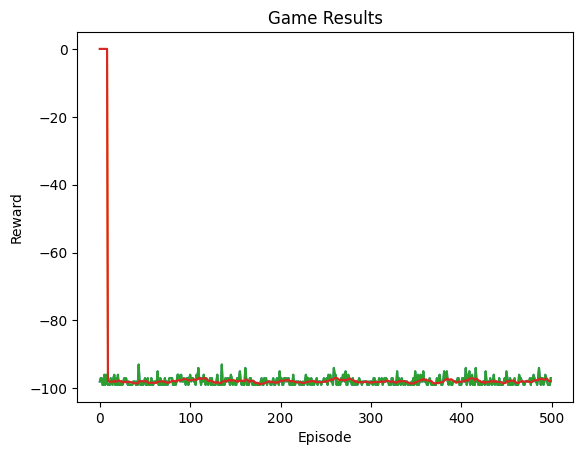

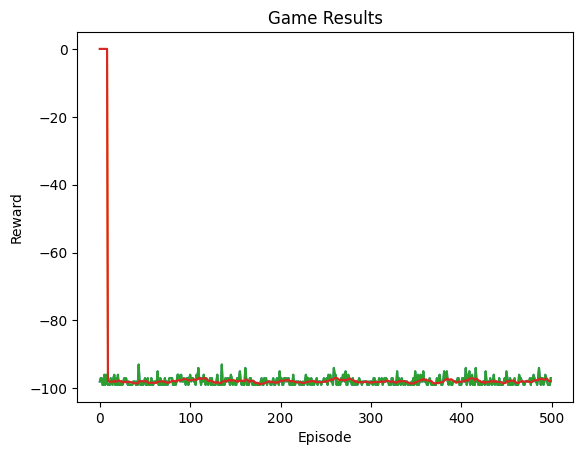

In [ ]:
env = TileGameEnv(layout=level4, max_card_usage=7, max_swap=2)  # TileGameEnv 인스턴스화

# 환경 및 에이전트 초기화
n_observations = len(env.reset())  # 환경으로부터 얻은 상태 크기
n_actions = len(env.action_space)  # 사용할 수 있는 카드 행동 유형의 수

BATCH_SIZE = 128

agent = DQNAgent(n_observations, n_actions, BATCH_SIZE)
file_name = 'model_checkpoint.pth'  # 검사할 파일 이름

if os.path.isfile(file_name):
    print("yes")
    checkpoint = torch.load('model_checkpoint.pth')
    agent.policy_net.load_state_dict(checkpoint['policy_model_state_dict'])
    agent.target_net.load_state_dict(checkpoint['target_model_state_dict'])
    agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# DQN 학습 시작
train_dqn(env, agent)